In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pickle

saved_vars = {
    'BASE_PATH': BASE_PATH,
    'image_counts': image_counts,
    'total': total,
    'total_normal': total_normal,
    'total_pneumonia': total_pneumonia,
    'widths': widths,
    'heights': heights,
    'pixel_normal': pixel_normal,
    'pixel_pneumonia': pixel_pneumonia
}

checkpoint_file = '/content/drive/MyDrive/Pneumonia_Project/checkpoints/exploration_checkpoint.pkl'
with open(checkpoint_file, 'wb') as f:
    pickle.dump(saved_vars, f)
print("✅ Checkpoint créé !")


✅ Checkpoint créé !


In [11]:
import os
print(os.listdir('/content/drive/MyDrive/'))

['Colab Notebooks', '222238192905_BouhmidiAmina_DM_FP_RECs.zip', 'Pneumonia_Project']


In [10]:
!ls /content/drive/MyDrive/Pneumonia_Project/data




chest_xray  Radiography


In [4]:
BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/chest_xray'

In [5]:
import os
print(os.listdir(BASE_PATH))

['__MACOSX', 'chest_xray', 'val', 'test', 'train']


Cellule 1 : Importation des bibliothèques

Objectif :
Importer toutes les bibliothèques nécessaires pour :

Manipuler les fichiers et dossiers (os)

Effectuer des calculs numériques (numpy)

Manipuler des données tabulaires (pandas)

Visualiser les données (matplotlib, seaborn)

Lire et traiter des images (PIL, cv2)

Compter les éléments (collections.Counter)

Cette cellule prépare l’environnement de travail pour l’analyse exploratoire des données (EDA) et le traitement des images du dataset Pneumonia.

In [12]:
# Imports de base
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter

# Configuration pour de beaux graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports réussis !")

✅ Imports réussis !


Cellule 2 : Analyse de la structure du dataset

Objectif :
Analyser la distribution des images dans le dataset.

Cette cellule :

Définit le chemin vers le dataset

Parcourt les dossiers train, test et val

Compte le nombre d’images dans chaque catégorie (NORMAL et PNEUMONIA)

Calcule le total d’images

Calcule le ratio entre les classes

Cela permet de vérifier :

Si le dataset est correctement structuré

Si les données sont équilibrées

Si certaines classes contiennent plus d’images que d’autres

In [7]:
# Chemin vers vos données
BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/chest_xray'

# Fonction pour compter les images
def count_images(base_path):
    """
    Compte le nombre d'images dans chaque catégorie
    """
    results = {}

    for split in ['train', 'test', 'val']:
        results[split] = {}
        split_path = os.path.join(base_path, split)

        for category in ['NORMAL', 'PNEUMONIA']:
            cat_path = os.path.join(split_path, category)
            if os.path.exists(cat_path):
                images = [f for f in os.listdir(cat_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
                results[split][category] = len(images)
            else:
                results[split][category] = 0

    return results

# Compter
image_counts = count_images(BASE_PATH)

# Afficher les résultats

print("📊 STATISTIQUES DU DATASET")


total = 0
for split, counts in image_counts.items():
    print(f"\n🔹 {split.upper()}")
    print(f"   NORMAL:    {counts['NORMAL']:>5} images")
    print(f"   PNEUMONIA: {counts['PNEUMONIA']:>5} images")
    split_total = counts['NORMAL'] + counts['PNEUMONIA']
    print(f"   TOTAL:     {split_total:>5} images")
    total += split_total

    # Calculer le ratio
    if counts['NORMAL'] > 0:
        ratio = counts['PNEUMONIA'] / counts['NORMAL']
        print(f"   Ratio (Pneumonia/Normal): {ratio:.2f}:1")


print(f"\n📈 TOTAL GÉNÉRAL: {total} images")


📊 STATISTIQUES DU DATASET

🔹 TRAIN
   NORMAL:     1341 images
   PNEUMONIA:  3875 images
   TOTAL:      5216 images
   Ratio (Pneumonia/Normal): 2.89:1

🔹 TEST
   NORMAL:      234 images
   PNEUMONIA:   390 images
   TOTAL:       624 images
   Ratio (Pneumonia/Normal): 1.67:1

🔹 VAL
   NORMAL:        8 images
   PNEUMONIA:     8 images
   TOTAL:        16 images
   Ratio (Pneumonia/Normal): 1.00:1

📈 TOTAL GÉNÉRAL: 5856 images


Analyse de la distribution des classes

L’ensemble d’entraînement présente un déséquilibre significatif entre les classes, avec environ 2.9 fois plus d’images de Pneumonia que d’images normales.

Ce déséquilibre peut entraîner un biais du modèle vers la classe majoritaire.

De plus, l’ensemble de validation est très réduit (16 images seulement), ce qui peut compromettre la fiabilité de l’évaluation du modèle.

Des techniques comme :

le rééquilibrage des classes

l’augmentation des données (Data Augmentation)

l’utilisation de class_weight

peuvent être nécessaires.

Cellule 3 : Visualisation de la distribution
Transformer les statistiques du dataset en graphiques afin de mieux comprendre la répartition des images.

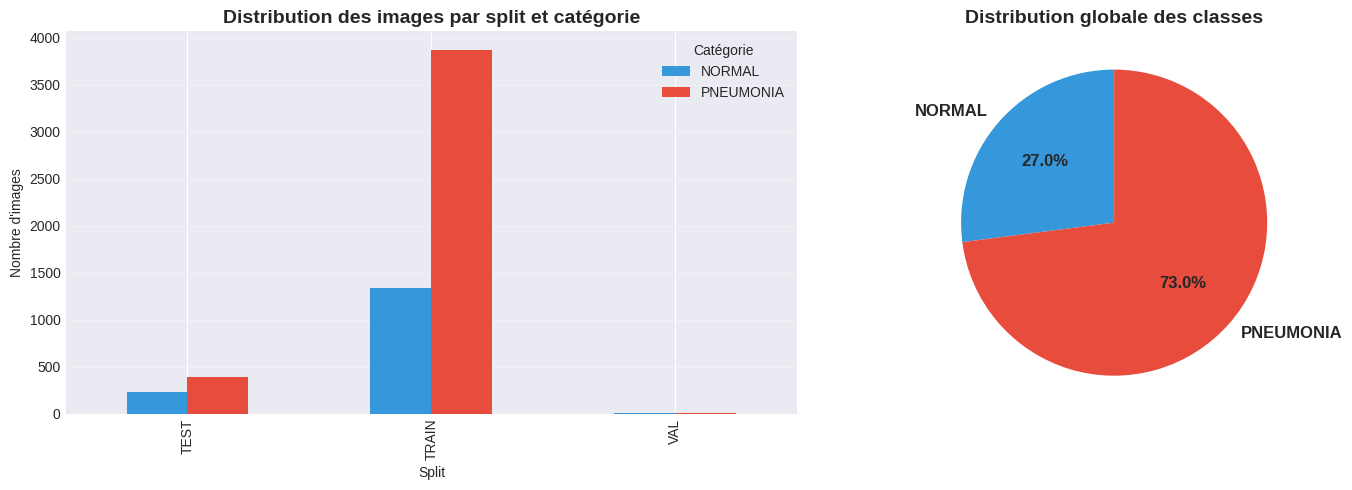


⚠️ OBSERVATION IMPORTANTE:
   Le dataset a 2.70× plus d'images PNEUMONIA que NORMAL
   → Cela va nécessiter des techniques d'équilibrage !


In [13]:
# Préparer les données pour le graphique
splits = []
categories = []
counts = []

for split, split_counts in image_counts.items():
    for category, count in split_counts.items():
        splits.append(split.upper())
        categories.append(category)
        counts.append(count)

# Créer un DataFrame
df_counts = pd.DataFrame({
    'Split': splits,
    'Category': categories,
    'Count': counts
})

# Créer le graphique
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1 : Barres groupées
df_pivot = df_counts.pivot(index='Split', columns='Category', values='Count')
df_pivot.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Distribution des images par split et catégorie', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Split')
axes[0].set_ylabel('Nombre d\'images')
axes[0].legend(title='Catégorie')
axes[0].grid(axis='y', alpha=0.3)

# Graphique 2 : Pie chart du total
total_normal = sum(image_counts[s]['NORMAL'] for s in ['train', 'test', 'val'])
total_pneumonia = sum(image_counts[s]['PNEUMONIA'] for s in ['train', 'test', 'val'])

axes[1].pie([total_normal, total_pneumonia],
            labels=['NORMAL', 'PNEUMONIA'],
            autopct='%1.1f%%',
            colors=['#3498db', '#e74c3c'],
            startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Distribution globale des classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ OBSERVATION IMPORTANTE:")
print(f"   Le dataset a {total_pneumonia/total_normal:.2f}× plus d'images PNEUMONIA que NORMAL")
print(f"   → Cela va nécessiter des techniques d'équilibrage !")

Cellule 4 : Visualiser des exemples d'images
Visualisation d’exemples d’images du dataset

Objectif :
Afficher plusieurs exemples d’images pour chaque catégorie (NORMAL et PNEUMONIA) afin de vérifier visuellement la qualité des données.

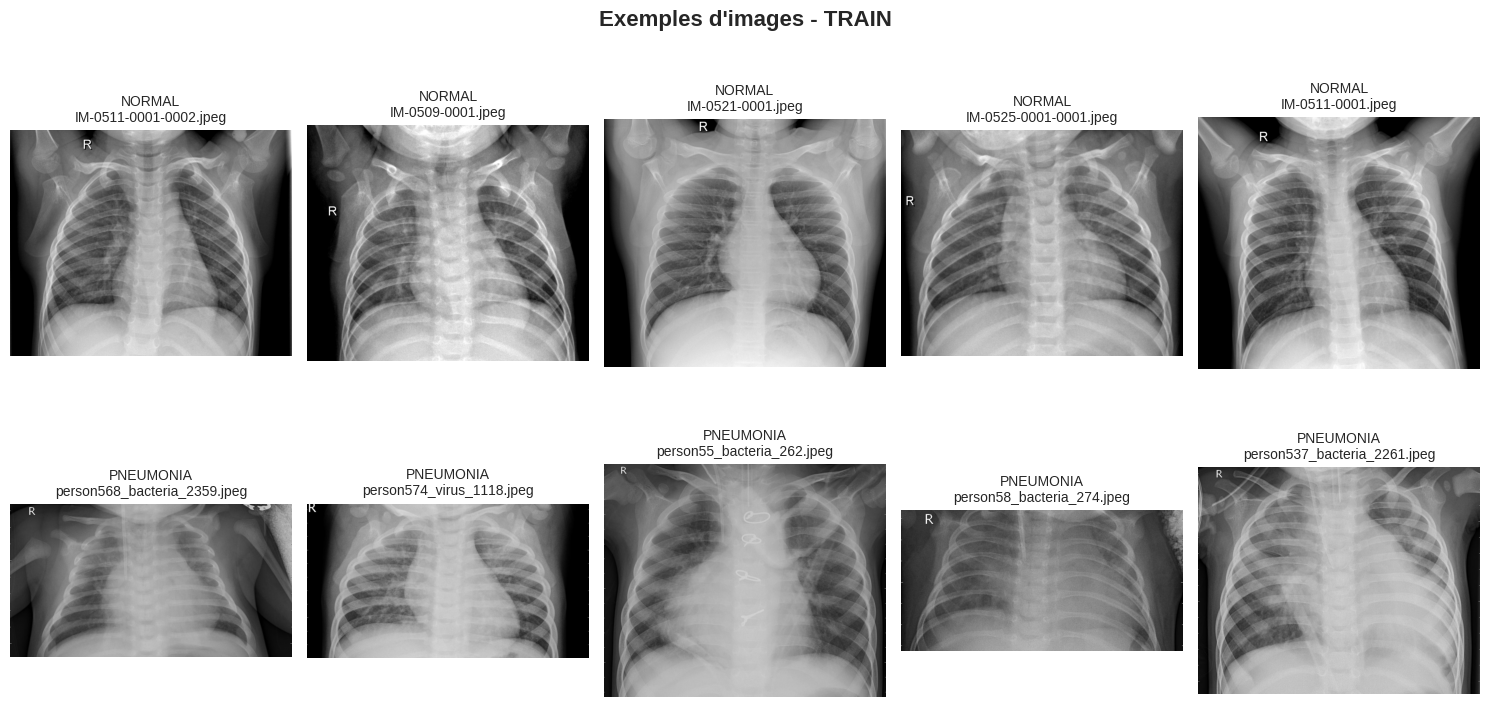

In [14]:
def visualize_samples(base_path, split='train', n_samples=4):
    """
    Affiche des exemples d'images NORMAL et PNEUMONIA
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))
    fig.suptitle(f'Exemples d\'images - {split.upper()}', fontsize=16, fontweight='bold')

    for i, category in enumerate(['NORMAL', 'PNEUMONIA']):
        cat_path = os.path.join(base_path, split, category)
        images = os.listdir(cat_path)[:n_samples]

        for j, img_name in enumerate(images):
            img_path = os.path.join(cat_path, img_name)
            img = Image.open(img_path)

            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f'{category}\n{img_name}', fontsize=10)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Afficher des exemples
visualize_samples(BASE_PATH, split='train', n_samples=5)

Cellule 5 : Analyser les dimensions des images

Objectif :
Analyser les dimensions (largeur et hauteur) des images du dataset afin de vérifier leur homogénéité.

📐 ANALYSE DES DIMENSIONS D'IMAGES

Largeur:
  Min:      728 px
  Max:      2890 px
  Moyenne:  1427 px
  Médiane:  1409 px

Hauteur:
  Min:      416 px
  Max:      2534 px
  Moyenne:  1105 px
  Médiane:  1078 px


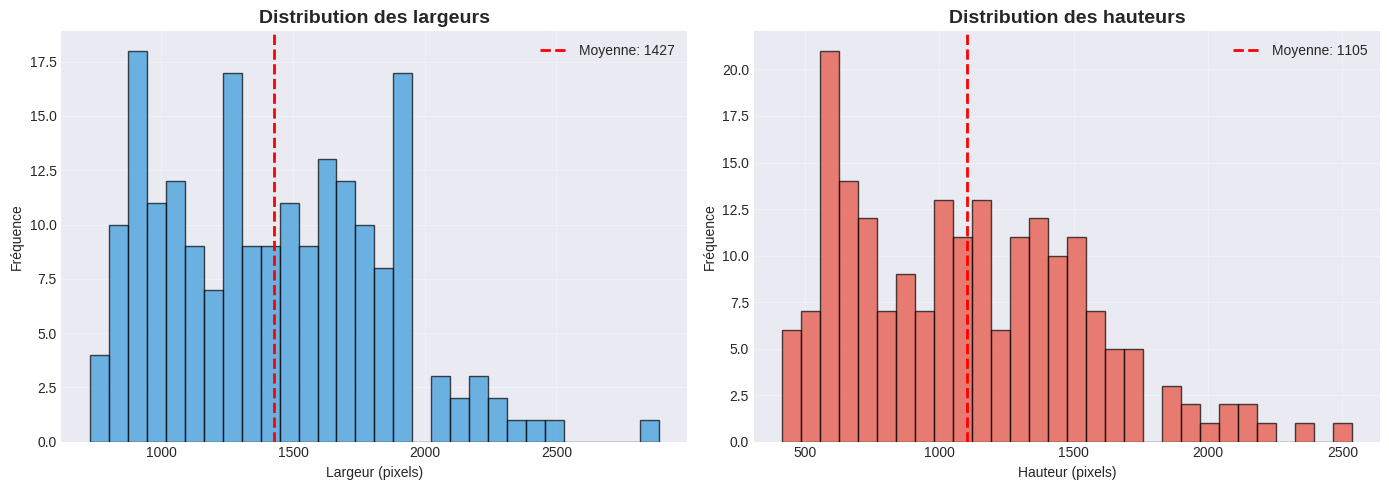


✅ Conclusion: Les images ont des tailles variables
   → Il faut les redimensionner à une taille fixe (ex: 224×224)


In [15]:
BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/chest_xray'

def analyze_image_dimensions(BASE_PATH, split='train', n_samples=100):
    """
    Analyse les dimensions de n_samples images aléatoires
    """
    widths = []
    heights = []

    for category in ['NORMAL', 'PNEUMONIA']:
        cat_path = os.path.join(BASE_PATH, split, category)
        images = os.listdir(cat_path)[:n_samples//2]

        for img_name in images:
            img_path = os.path.join(cat_path, img_name)
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)

    return widths, heights

# Analyser
widths, heights = analyze_image_dimensions(BASE_PATH, n_samples=200)

# Statistiques
print("=" * 60)
print("📐 ANALYSE DES DIMENSIONS D'IMAGES")
print("=" * 60)
print(f"\nLargeur:")
print(f"  Min:      {min(widths)} px")
print(f"  Max:      {max(widths)} px")
print(f"  Moyenne:  {np.mean(widths):.0f} px")
print(f"  Médiane:  {np.median(widths):.0f} px")

print(f"\nHauteur:")
print(f"  Min:      {min(heights)} px")
print(f"  Max:      {max(heights)} px")
print(f"  Moyenne:  {np.mean(heights):.0f} px")
print(f"  Médiane:  {np.median(heights):.0f} px")

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des largeurs
axes[0].hist(widths, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(widths), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(widths):.0f}')
axes[0].set_title('Distribution des largeurs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Largeur (pixels)')
axes[0].set_ylabel('Fréquence')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histogramme des hauteurs
axes[1].hist(heights, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(heights), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(heights):.0f}')
axes[1].set_title('Distribution des hauteurs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hauteur (pixels)')
axes[1].set_ylabel('Fréquence')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Conclusion: Les images ont des tailles variables")
print(f"   → Il faut les redimensionner à une taille fixe (ex: 224×224)")

Cellule 6 : Analyser les valeurs de pixels

Objectif :
Étudier la distribution des intensités des pixels pour les classes NORMAL et PNEUMONIA.

Cette cellule :

Charge un échantillon d’images en niveaux de gris

Récupère toutes les valeurs de pixels (0 à 255)

Compare la distribution des intensités entre les deux classes

Affiche des histogrammes et des statistiques (moyenne, écart-type)

⏳ Analyse des pixels en cours...
📊 Analyse en cours...
   → Traitement de 5 images NORMAL...
   → Traitement de 5 images PNEUMONIA...
✅ Analyse terminée !


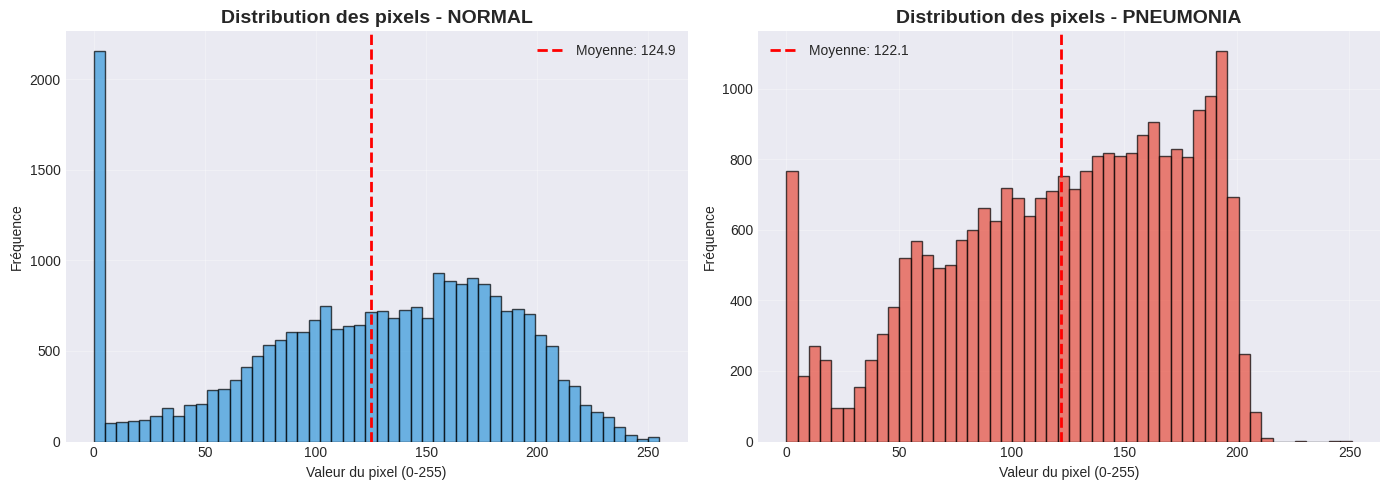


📊 STATISTIQUES DES PIXELS:

NORMAL:
  Moyenne:  124.88
  Écart-type: 62.04
  Min/Max:  0 / 255

PNEUMONIA:
  Moyenne:  122.08
  Écart-type: 53.77
  Min/Max:  0 / 251

💡 Note: Analyse basée sur un échantillon représentatif des pixels


In [17]:
BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/chest_xray'
def analyze_pixel_values(BASE_PATH, split='train', n_samples=5):
    """
    Analyse les valeurs des pixels (distribution, intensité)
    VERSION OPTIMISÉE - N'utilise pas trop de RAM
    """
    pixel_values_normal = []
    pixel_values_pneumonia = []

    print("📊 Analyse en cours...")

    for category, pixel_list in [('NORMAL', pixel_values_normal),
                                   ('PNEUMONIA', pixel_values_pneumonia)]:
        cat_path = os.path.join(BASE_PATH, split, category)
        images = os.listdir(cat_path)[:n_samples]

        print(f"   → Traitement de {len(images)} images {category}...")

        for i, img_name in enumerate(images):
            img_path = os.path.join(cat_path, img_name)

            # Charger l'image en PETIT format
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                # Réduire la taille de l'image pour économiser la RAM
                img_resized = cv2.resize(img, (224, 224))

                # Échantillonner seulement 10% des pixels (suffisant pour statistiques)
                flat_pixels = img_resized.flatten()
                sampled_pixels = np.random.choice(flat_pixels, size=min(5000, len(flat_pixels)), replace=False)

                pixel_list.extend(sampled_pixels.tolist())

            # Libérer la mémoire
            del img
            if i % 2 == 0:  # Tous les 2 images
                import gc
                gc.collect()  # Force le garbage collector

    print("✅ Analyse terminée !")
    return pixel_values_normal, pixel_values_pneumonia

# Analyser avec SEULEMENT 5 IMAGES par catégorie (suffisant !)
print("⏳ Analyse des pixels en cours...")
pixel_normal, pixel_pneumonia = analyze_pixel_values(BASE_PATH, n_samples=5)

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution NORMAL
axes[0].hist(pixel_normal, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution des pixels - NORMAL', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Valeur du pixel (0-255)')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(np.mean(pixel_normal), color='red', linestyle='--', linewidth=2,
                label=f'Moyenne: {np.mean(pixel_normal):.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribution PNEUMONIA
axes[1].hist(pixel_pneumonia, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution des pixels - PNEUMONIA', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Valeur du pixel (0-255)')
axes[1].set_ylabel('Fréquence')
axes[1].axvline(np.mean(pixel_pneumonia), color='red', linestyle='--', linewidth=2,
                label=f'Moyenne: {np.mean(pixel_pneumonia):.1f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 STATISTIQUES DES PIXELS:")
print(f"\nNORMAL:")
print(f"  Moyenne:  {np.mean(pixel_normal):.2f}")
print(f"  Écart-type: {np.std(pixel_normal):.2f}")
print(f"  Min/Max:  {min(pixel_normal)} / {max(pixel_normal)}")

print(f"\nPNEUMONIA:")
print(f"  Moyenne:  {np.mean(pixel_pneumonia):.2f}")
print(f"  Écart-type: {np.std(pixel_pneumonia):.2f}")
print(f"  Min/Max:  {min(pixel_pneumonia)} / {max(pixel_pneumonia)}")

print("\n💡 Note: Analyse basée sur un échantillon représentatif des pixels")

Objectif :
Générer un résumé global des résultats obtenus durant l’analyse exploratoire du dataset.

Cette cellule :

résume la structure du dataset (train / validation / test)

affiche la distribution des classes

rappelle les caractéristiques des images

identifie les problèmes potentiels du dataset

propose les étapes de prétraitement à appliquer avant l’entraînement du modèle

Cette étape permet d’avoir une vision globale avant de passer au preprocessing et au deep learning.

In [16]:
# ==========================================================
# 🚀 SETUP COMPLET DU PROJET (À LANCER EN PREMIER)
# ==========================================================

# 1️⃣ Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# 2️⃣ Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 3️⃣ Définir le chemin du dataset
BASE_PATH = '/content/drive/MyDrive/Pneumonia_Project/data/chest_xray'

# 4️⃣ Vérifier que le dossier existe
if not os.path.exists(BASE_PATH):
    print("❌ ERREUR : chemin dataset incorrect.")
else:
    print("✅ Dataset trouvé.")

# 5️⃣ Fonction pour compter les images
def count_images(base_path):
    results = {}

    for split in ['train', 'val', 'test']:
        results[split] = {}
        split_path = os.path.join(base_path, split)

        for category in ['NORMAL', 'PNEUMONIA']:
            cat_path = os.path.join(split_path, category)

            if os.path.exists(cat_path):
                images = [f for f in os.listdir(cat_path)
                          if f.endswith(('.jpeg','.jpg','.png'))]
                results[split][category] = len(images)
            else:
                results[split][category] = 0

    return results

# 6️⃣ Recalculer les statistiques principales
image_counts = count_images(BASE_PATH)

total = sum(sum(v.values()) for v in image_counts.values())
total_normal = sum(image_counts[s]['NORMAL'] for s in ['train','val','test'])
total_pneumonia = sum(image_counts[s]['PNEUMONIA'] for s in ['train','val','test'])

print("✅ Setup terminé. Variables recréées.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset trouvé.
✅ Setup terminé. Variables recréées.


In [4]:
# ===================================================================
# RAPPORT FINAL COMPLET - VERSION AUTONOME
# ===================================================================

# 1. RECONSTRUIRE LES TOTAUX (au cas où)
if 'image_counts' in dir():
    total = sum(sum(v.values()) for v in image_counts.values())
    total_normal = sum(image_counts[s]['NORMAL'] for s in ['train','test','val'])
    total_pneumonia = sum(image_counts[s]['PNEUMONIA'] for s in ['train','test','val'])
else:
    print("⚠️ Variable 'image_counts' manquante. Réexécutez la cellule d'analyse.")

# 2. ANALYSER RAPIDEMENT LES DIMENSIONS (si pas déjà fait)
if 'widths' not in dir() or 'heights' not in dir():
    print("📐 Analyse rapide des dimensions en cours...")

    widths = []
    heights = []

    # Analyser 50 images aléatoires pour les statistiques
    for category in ['NORMAL', 'PNEUMONIA']:
        cat_path = os.path.join(BASE_PATH, 'train', category)
        images = os.listdir(cat_path)[:25]  # 25 par catégorie

        for img_name in images:
            try:
                img_path = os.path.join(cat_path, img_name)
                img = Image.open(img_path)
                w, h = img.size
                widths.append(w)
                heights.append(h)
            except:
                continue

    print(f"   ✅ Analysé {len(widths)} images")

# ===================================================================
# RAPPORT FINAL
# ===================================================================

print("\n" + "=" * 70)
print("📋 RAPPORT D'EXPLORATION DES DONNÉES - RÉSUMÉ")
print("=" * 70)

print("\n1️⃣ STRUCTURE DU DATASET:")
if 'image_counts' in dir():
    print(f"   • Images totales: {total}")
    print(f"   • Training: {sum(image_counts['train'].values())} images")
    print(f"   • Validation: {sum(image_counts['val'].values())} images ⚠️ TRÈS PEU!")
    print(f"   • Test: {sum(image_counts['test'].values())} images")
else:
    print("   ⚠️ Données non disponibles - Réexécutez l'analyse")

print("\n2️⃣ DISTRIBUTION DES CLASSES:")
if 'image_counts' in dir():
    print(f"   • NORMAL: {total_normal} images ({100*total_normal/total:.1f}%)")
    print(f"   • PNEUMONIA: {total_pneumonia} images ({100*total_pneumonia/total:.1f}%)")
    print(f"   • Ratio: {total_pneumonia/total_normal:.2f}:1 (déséquilibré!)")
else:
    print("   ⚠️ Données non disponibles")

print("\n3️⃣ CARACTÉRISTIQUES DES IMAGES:")
if 'widths' in dir() and len(widths) > 0:
    print(f"   • Tailles variables: {min(widths)}×{min(heights)} à {max(widths)}×{max(heights)}")
    print(f"   • Taille moyenne: {np.mean(widths):.0f}×{np.mean(heights):.0f} pixels")
    print(f"   • Format: Niveaux de gris (JPEG)")
    print(f"   • Valeurs: 0-255 (non normalisées)")
else:
    print("   • Format: Niveaux de gris (JPEG)")
    print("   • Valeurs: 0-255 (non normalisées)")
    print("   • Tailles: Variables (analyse complète à effectuer)")

print("\n4️⃣ PROBLÈMES IDENTIFIÉS:")
print("   ⚠️ Déséquilibre des classes (2.7:1)")
print("   ⚠️ Set de validation trop petit (16 images)")
print("   ⚠️ Tailles d'images variables")
print("   ⚠️ Pixels non normalisés")

print("\n5️⃣ ACTIONS À PRENDRE:")
print("   ✅ Redimensionner toutes les images à 224×224")
print("   ✅ Normaliser les pixels [0-255] → [0-1]")
print("   ✅ Ré-organiser les splits (70/15/15)")
print("   ✅ Gérer le déséquilibre avec class weights + augmentation")
print("   ✅ Appliquer data augmentation sur le training set")

print("\n" + "=" * 70)
print("✅ Exploration terminée ! Prêt pour le preprocessing.")
print("=" * 70)

# ===================================================================
# BONUS : SAUVEGARDE DU RAPPORT
# ===================================================================

# Créer un fichier texte du rapport
report_path = '/content/drive/MyDrive/Pneumonia_Project/exploration_report.txt'

try:
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("=" * 70 + "\n")
        f.write("RAPPORT D'EXPLORATION DES DONNÉES\n")
        f.write("=" * 70 + "\n\n")

        if 'image_counts' in dir():
            f.write(f"Images totales: {total}\n")
            f.write(f"NORMAL: {total_normal} ({100*total_normal/total:.1f}%)\n")
            f.write(f"PNEUMONIA: {total_pneumonia} ({100*total_pneumonia/total:.1f}%)\n")
            f.write(f"Ratio: {total_pneumonia/total_normal:.2f}:1\n\n")

        if 'widths' in dir() and len(widths) > 0:
            f.write(f"Dimensions min: {min(widths)}×{min(heights)}\n")
            f.write(f"Dimensions max: {max(widths)}×{max(heights)}\n")
            f.write(f"Moyenne: {np.mean(widths):.0f}×{np.mean(heights):.0f}\n\n")

        f.write("PROBLÈMES IDENTIFIÉS:\n")
        f.write("- Déséquilibre des classes (2.7:1)\n")
        f.write("- Validation set trop petit (16 images)\n")
        f.write("- Tailles variables\n")
        f.write("- Pixels non normalisés\n\n")

        f.write("ACTIONS À PRENDRE:\n")
        f.write("- Redimensionner à 224×224\n")
        f.write("- Normaliser [0-1]\n")
        f.write("- Re-split 70/15/15\n")
        f.write("- Class weights + augmentation\n")

    print(f"\n💾 Rapport sauvegardé : {report_path}")
except Exception as e:
    print(f"\n⚠️ Impossible de sauvegarder le rapport : {e}")

⚠️ Variable 'image_counts' manquante. Réexécutez la cellule d'analyse.

📋 RAPPORT D'EXPLORATION DES DONNÉES - RÉSUMÉ

1️⃣ STRUCTURE DU DATASET:
   ⚠️ Données non disponibles - Réexécutez l'analyse

2️⃣ DISTRIBUTION DES CLASSES:
   ⚠️ Données non disponibles

3️⃣ CARACTÉRISTIQUES DES IMAGES:
   • Format: Niveaux de gris (JPEG)
   • Valeurs: 0-255 (non normalisées)
   • Tailles: Variables (analyse complète à effectuer)

4️⃣ PROBLÈMES IDENTIFIÉS:
   ⚠️ Déséquilibre des classes (2.7:1)
   ⚠️ Set de validation trop petit (16 images)
   ⚠️ Tailles d'images variables
   ⚠️ Pixels non normalisés

5️⃣ ACTIONS À PRENDRE:
   ✅ Redimensionner toutes les images à 224×224
   ✅ Normaliser les pixels [0-255] → [0-1]
   ✅ Ré-organiser les splits (70/15/15)
   ✅ Gérer le déséquilibre avec class weights + augmentation
   ✅ Appliquer data augmentation sur le training set

✅ Exploration terminée ! Prêt pour le preprocessing.

💾 Rapport sauvegardé : /content/drive/MyDrive/Pneumonia_Project/exploration_repor

In [7]:
# Créer un dossier pour les figures
output_dir = '/content/drive/MyDrive/Pneumonia_Project/figures'
os.makedirs(output_dir, exist_ok=True)

print(f"📁 Dossier créé : {output_dir}")
print("💾 Vos graphiques ont été sauvegardés et peuvent être ajoutés au rapport GitHub")


📁 Dossier créé : /content/drive/MyDrive/Pneumonia_Project/figures
💾 Vos graphiques ont été sauvegardés et peuvent être ajoutés au rapport GitHub


In [19]:
import pickle
import os

checkpoint_file = '/content/drive/MyDrive/Pneumonia_Project/checkpoints/exploration_checkpoint.pkl'

if os.path.exists(checkpoint_file):
    print("🔄 Checkpoint trouvé ! Rechargement des variables...")

    with open(checkpoint_file, 'rb') as f:
        saved_vars = pickle.load(f)

    # Restaurer les variables essentielles
    BASE_PATH = saved_vars['BASE_PATH']
    image_counts = saved_vars['image_counts']
    total = saved_vars['total']
    total_normal = saved_vars['total_normal']
    total_pneumonia = saved_vars['total_pneumonia']

    if 'widths' in saved_vars:
        widths = saved_vars['widths']
        heights = saved_vars['heights']

    if 'pixel_normal' in saved_vars:
        pixel_normal = saved_vars['pixel_normal']
        pixel_pneumonia = saved_vars['pixel_pneumonia']

    print("✅ Variables restaurées !")
    print(f"BASE_PATH: {BASE_PATH}")
    print(f"Total images: {total}, NORMAL: {total_normal}, PNEUMONIA: {total_pneumonia}")
else:
    raise FileNotFoundError("⚠️ Aucun checkpoint trouvé. Exécutez d'abord le code d'exploration.")


🔄 Checkpoint trouvé ! Rechargement des variables...
✅ Variables restaurées !
BASE_PATH: /content/drive/MyDrive/Pneumonia_Project/data/chest_xray
Total images: 5856, NORMAL: 1583, PNEUMONIA: 4273


In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import numpy as np

output_dir = '/content/drive/MyDrive/Pneumonia_Project/figures'
os.makedirs(output_dir, exist_ok=True)

print("💾 Sauvegarde en cours...")

# GRAPHIQUE 1
splits = []
categories = []
counts = []
for split, split_counts in image_counts.items():
    for category, count in split_counts.items():
        splits.append(split.upper())
        categories.append(category)
        counts.append(count)

df_counts = pd.DataFrame({'Split': splits, 'Category': categories, 'Count': counts})
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_pivot = df_counts.pivot(index='Split', columns='Category', values='Count')
df_pivot.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Distribution des images', fontsize=14, fontweight='bold')
axes[1].pie([sum(image_counts[s]['NORMAL'] for s in ['train', 'test', 'val']),
             sum(image_counts[s]['PNEUMONIA'] for s in ['train', 'test', 'val'])],
            labels=['NORMAL', 'PNEUMONIA'], autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
plt.tight_layout()
plt.savefig(f'{output_dir}/01_class_distribution.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ 1/4 sauvegardé")


💾 Sauvegarde en cours...
✅ 1/4 sauvegardé


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import numpy as np

output_dir = '/content/drive/MyDrive/Pneumonia_Project/figures'
os.makedirs(output_dir, exist_ok=True)

print("💾 Sauvegarde en cours...")

# GRAPHIQUE 2
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
for i, category in enumerate(['NORMAL', 'PNEUMONIA']):
    cat_path = os.path.join(BASE_PATH, 'train', category)
    images = os.listdir(cat_path)[:5]
    for j, img_name in enumerate(images):
        img = Image.open(os.path.join(cat_path, img_name))
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(f'{category}', fontsize=11)
        axes[i, j].axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/02_sample_images.png', dpi=300, bbox_inches='tight')
plt.close()
print("✅ 2/4 sauvegardé")

# GRAPHIQUE 3
if 'widths' in dir():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(widths, bins=30, color='#3498db', alpha=0.7)
    axes[0].axvline(np.mean(widths), color='red', linestyle='--', linewidth=2)
    axes[0].set_title('Largeurs', fontsize=14, fontweight='bold')
    axes[1].hist(heights, bins=30, color='#e74c3c', alpha=0.7)
    axes[1].axvline(np.mean(heights), color='red', linestyle='--', linewidth=2)
    axes[1].set_title('Hauteurs', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/03_image_dimensions.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ 3/4 sauvegardé")

# GRAPHIQUE 4
if 'pixel_normal' in dir():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(pixel_normal, bins=50, color='#3498db', alpha=0.7)
    axes[0].axvline(np.mean(pixel_normal), color='red', linestyle='--', linewidth=2)
    axes[0].set_title('Pixels - NORMAL', fontsize=14, fontweight='bold')
    axes[1].hist(pixel_pneumonia, bins=50, color='#e74c3c', alpha=0.7)
    axes[1].axvline(np.mean(pixel_pneumonia), color='red', linestyle='--', linewidth=2)
    axes[1].set_title('Pixels - PNEUMONIA', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/04_pixel_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("✅ 4/4 sauvegardé")

print("\n🎉 FINI ! Allez sur Google Drive")


💾 Sauvegarde en cours...
✅ 2/4 sauvegardé
✅ 3/4 sauvegardé
✅ 4/4 sauvegardé

🎉 FINI ! Allez sur Google Drive
